In [57]:
import os
import numpy as np
import plotly.io as pio
from matplotlib import pyplot as plt

import prepare_data
import run_detection
import plot_detection

pio.renderers.default = 'vscode'
%matplotlib inline

# Data Inspection

## Prepare Data

Configure file paths

In [58]:
DATA_DIR = 'assets/'

IMG_EUV_DIR = DATA_DIR + 'Img_EUV/'

ALL_HE_DIR = DATA_DIR + 'All_He/'
SELECT_HE_DIR = DATA_DIR + 'Selected_He/'

OUTPUT_DIR = DATA_DIR + 'Output/'
SINGLE_MAPS_DIR = OUTPUT_DIR + 'Single_Maps/'

REPROJECT_MAG_SAVE_DIR = OUTPUT_DIR + 'Reprojected_Mag/'

DICT_DATE_STR_FORMAT = '%Y_%m_%d__%H_%M'

OUTPUT_DIR = DATA_DIR + 'Output/'
SINGLE_MAPS_DIR = OUTPUT_DIR + 'Single_Maps/'

Specify date range and file path for saved ensemble maps
- EUV images must be renamed to match the string format DICT_DATE_STR_FORMAT

In [68]:
# ENSEMBLE_MAPS_DIR = OUTPUT_DIR + 'Ensemble_Maps_v0_3/'
# ENSEMBLE_MAPS_DIR = OUTPUT_DIR + 'Band_Pass/'
# ENSEMBLE_MAPS_DIR = OUTPUT_DIR + 'Rescale/'
ENSEMBLE_MAPS_DIR = OUTPUT_DIR + 'Rescale_Center/'

PRE_PROCESS_MAP_SAVE_DIR = ENSEMBLE_MAPS_DIR + 'Preprocess_Map_Files/'
ENSEMBLE_MAP_SAVE_DIR = ENSEMBLE_MAPS_DIR + 'Ensemble_Map_Files/'

# GMU period early in Solar Cycle 24
# date_range = ('2012_04_01__00_00', '2012_09_01__00_00')
# ENSEMBLE_MAP_IMAGE_DIR = ENSEMBLE_MAPS_DIR + '2012_04_2012_08/'

# June of GMU period early in Solar Cycle 24
date_range = ('2012_06_01__00_00', '2012_07_01__00_00')
ENSEMBLE_MAP_IMAGE_DIR = ENSEMBLE_MAPS_DIR + '2012_06/'

# Select few dates for analysis
# date_range = None
# ENSEMBLE_MAP_IMAGE_DIR = ENSEMBLE_MAPS_DIR + 'Selected_Maps/'

# All dates
# date_range = ('2000_01_01__00_00', '2020_01_01__00_00')

# CR 2136
# date_range = ('2013_04_01__00_00', '2013_06_01__00_00')

# CR 2151
# date_range = ('2014_06_01__00_00', '2014_06_30__00_00')

Rename Data
- He I and magnetogram FITS files are renamed automatically

In [ ]:
# Delete all gzipped files after renaming
remove_gzip = True

# Rename all He FITS files to include observation date in title
prepare_data.rename_dir(ALL_HE_DIR, remove_gzip)

Extract Data from File System

In [4]:
# Extract data arrays from He FITS files
HE_FITS_DICT = prepare_data.extract_he(date_range, ALL_HE_DIR, SELECT_HE_DIR)
HE_DATE_LIST = list(HE_FITS_DICT.keys())
HE_DATE_LIST.sort()

# Extract EUV images from image files
EUV_DICT = prepare_data.extract_comparison_ims(IMG_EUV_DIR)

## Available Data

In [ ]:
print('Available Datetimes for He I Observations:')
prepare_data.display_dates(HE_DATE_LIST)

He I FITS File Content

In [ ]:
date_str = '2015_03_31__18_13'
# date_str = '2013_04_17__18_39'
# date_str = '2014_06_06__17_46'

cmaps = [plt.cm.RdBu, plt.cm.afmhot, plt.cm.gray]

plot_detection.plot_fits_content(HE_FITS_DICT, date_str, cmaps)

# Pre-Process

## Single Observation

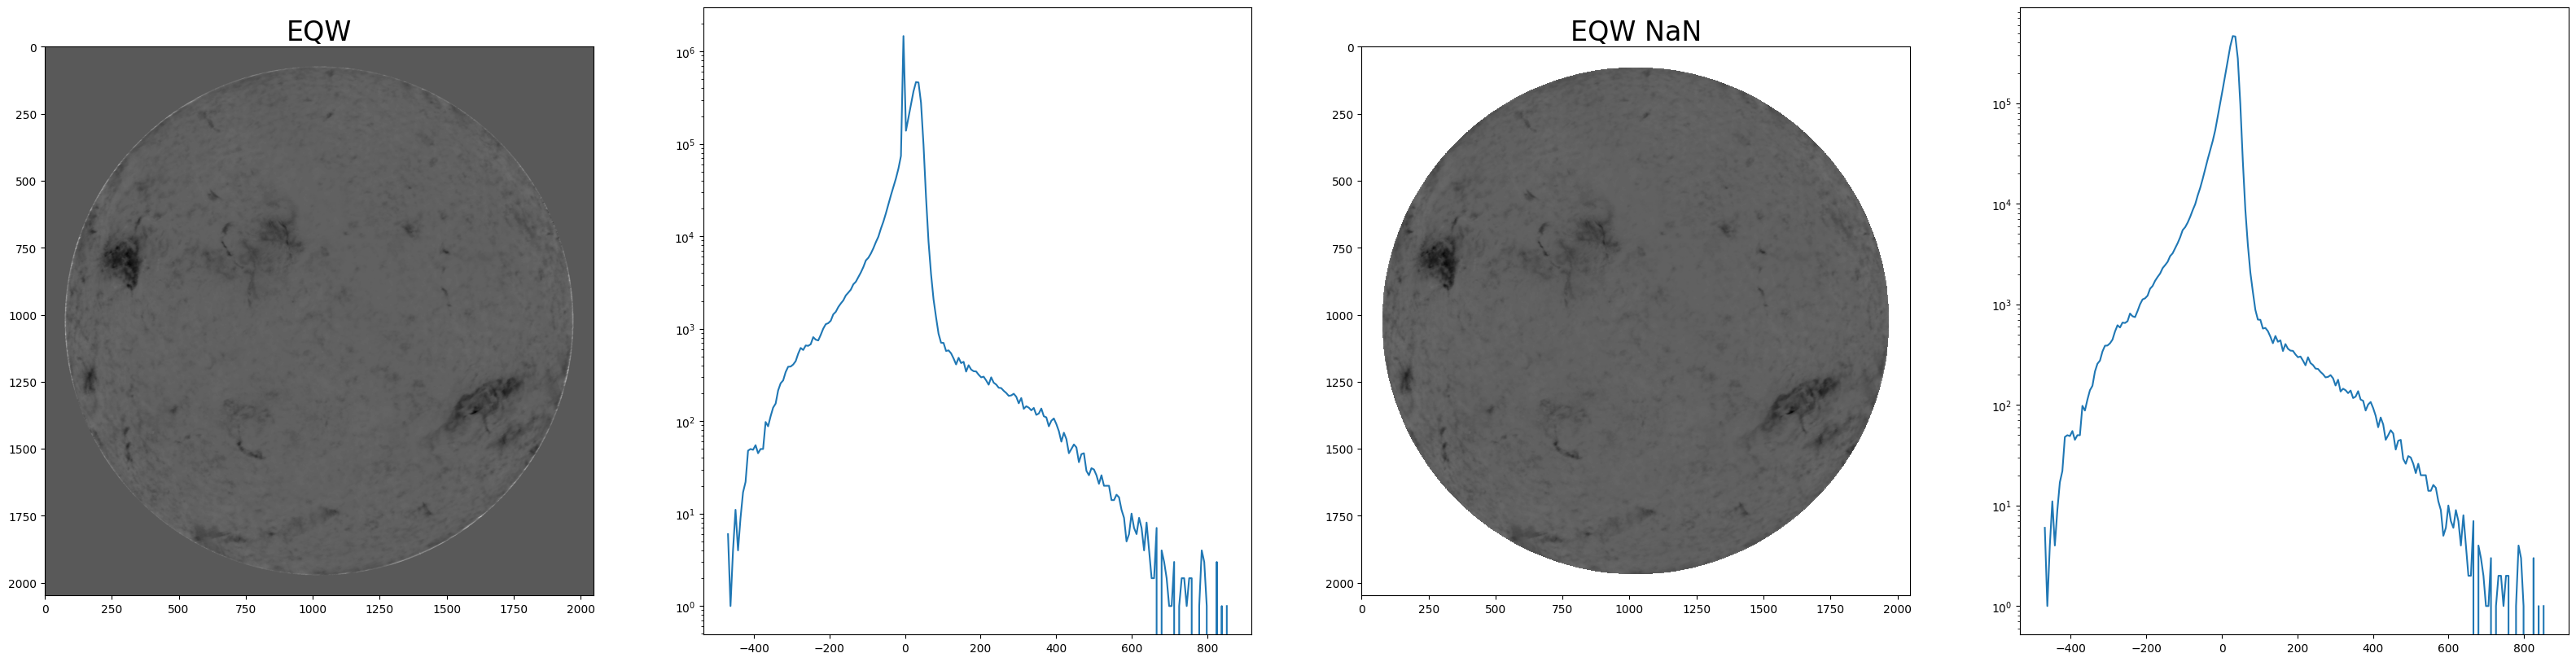

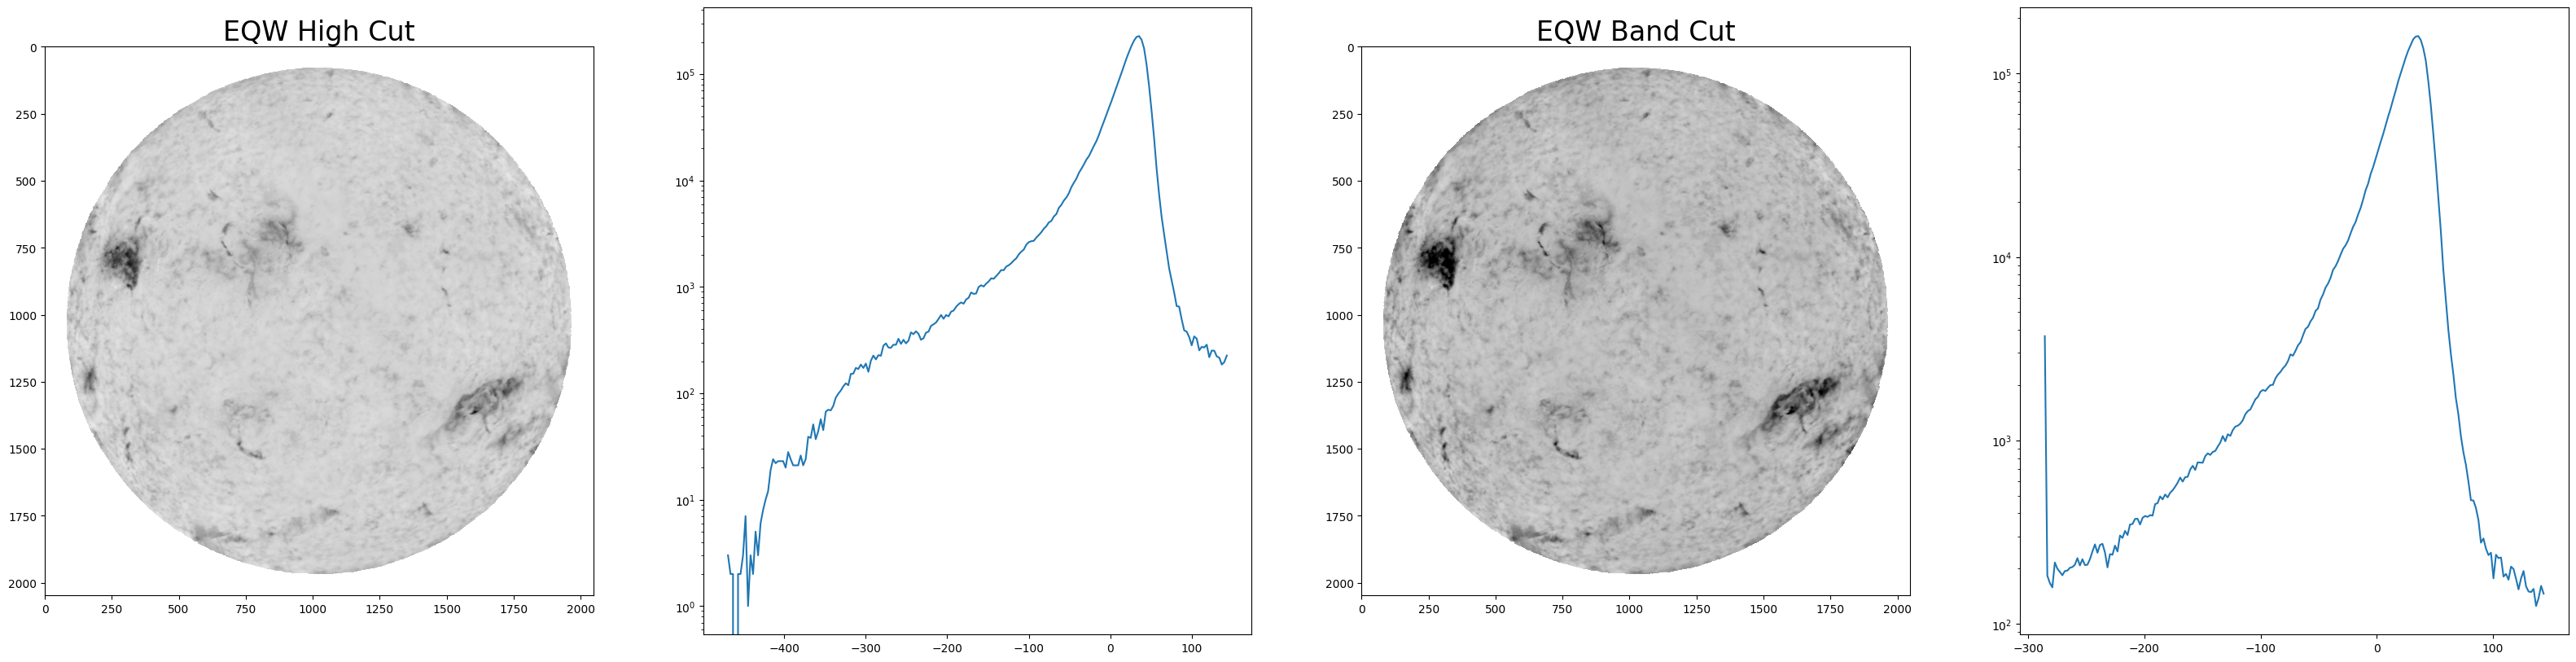

In [7]:
date_str = '2012_05_07__17_59'


raw_eqw = HE_FITS_DICT[date_str][0]
eqw_band_cut, eqw_high_cut, eqw_nan = run_detection.pre_process_eqw_v0_1(
    raw_eqw, peak_count_cutoff_percent=0.1
)

arrays = [raw_eqw, eqw_nan, eqw_high_cut, eqw_band_cut]
titles = ['EQW', 'EQW NaN', 'EQW High Cut', 'EQW Band Cut']

plot_detection.plot_hists(arrays[0:2], titles[0:2], semilogy=True)
plot_detection.plot_hists(arrays[2:4], titles[2:4], semilogy=True)

# Parameters

## Threshold

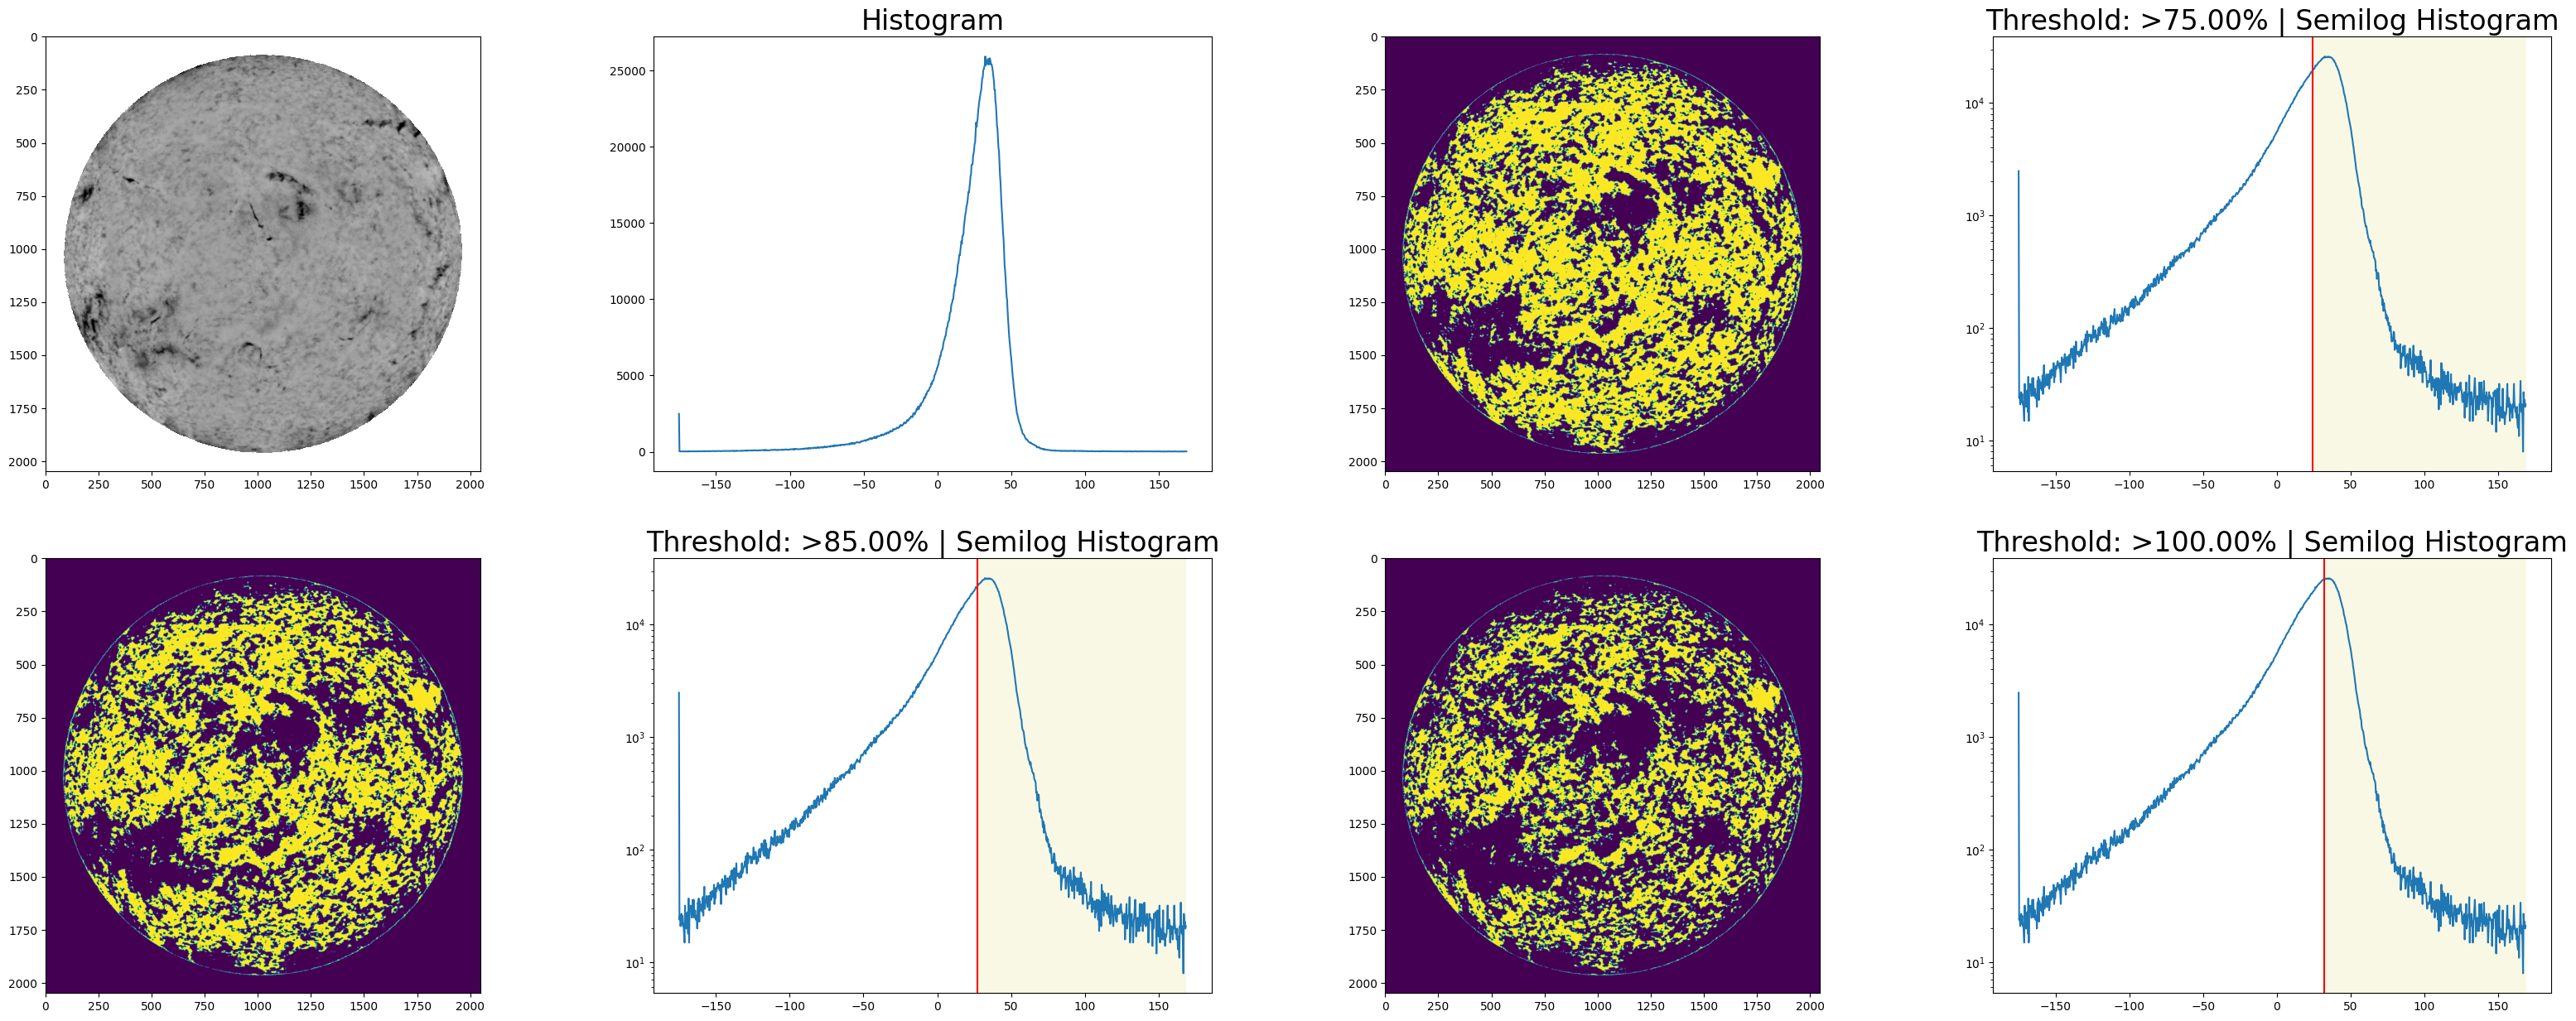

In [8]:
date_str = '2012_06_22__18_13'

raw_eqw = HE_FITS_DICT[date_str][0]
pre_processed_map = run_detection.pre_process_eqw_v0_1(raw_eqw)[0]

plot_detection.plot_thresholds(pre_processed_map, bounds=[75, 85, 100],
                               bounds_as_percent=True)

## Structuring Element Radius

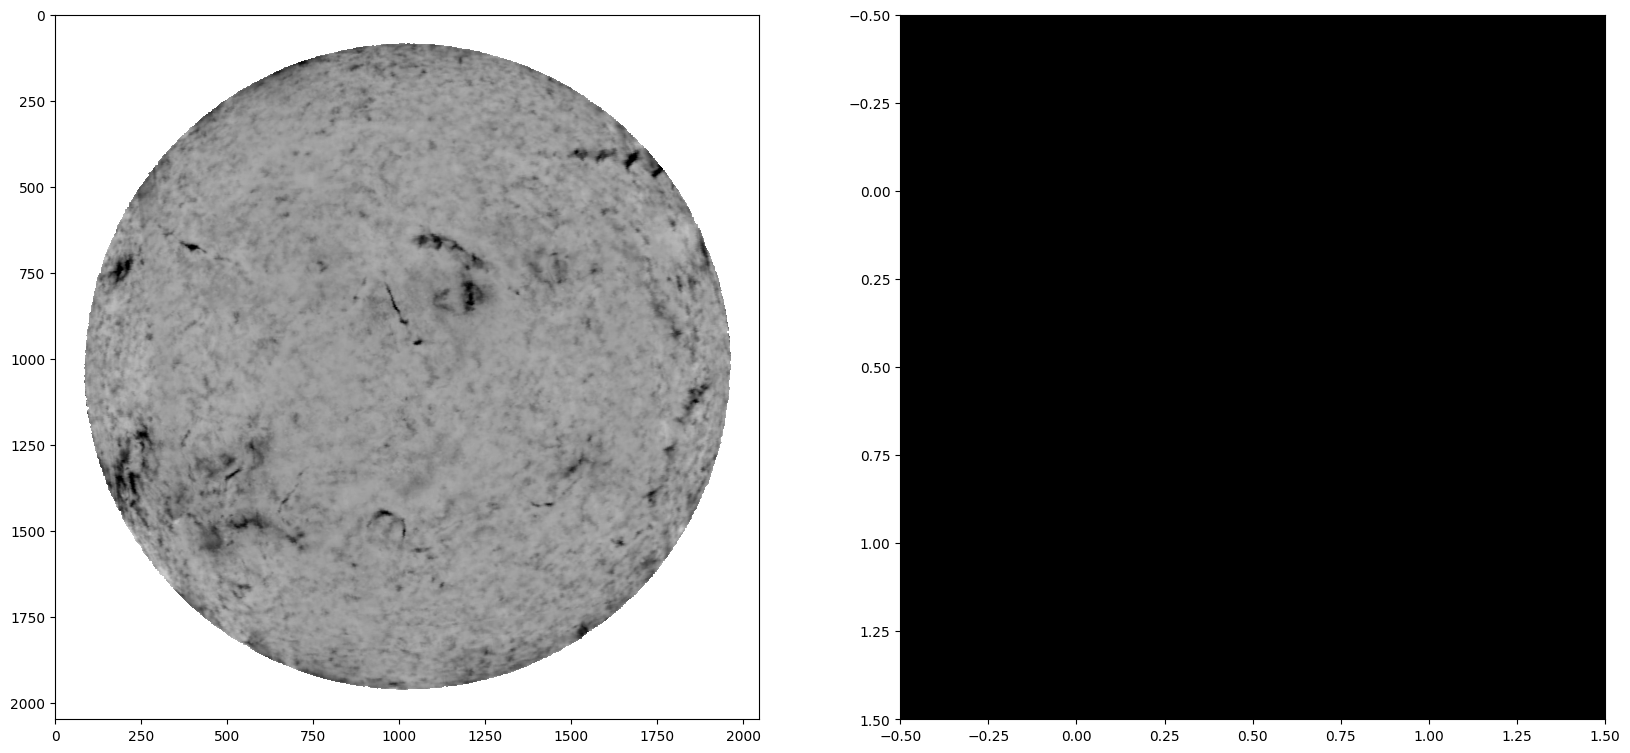

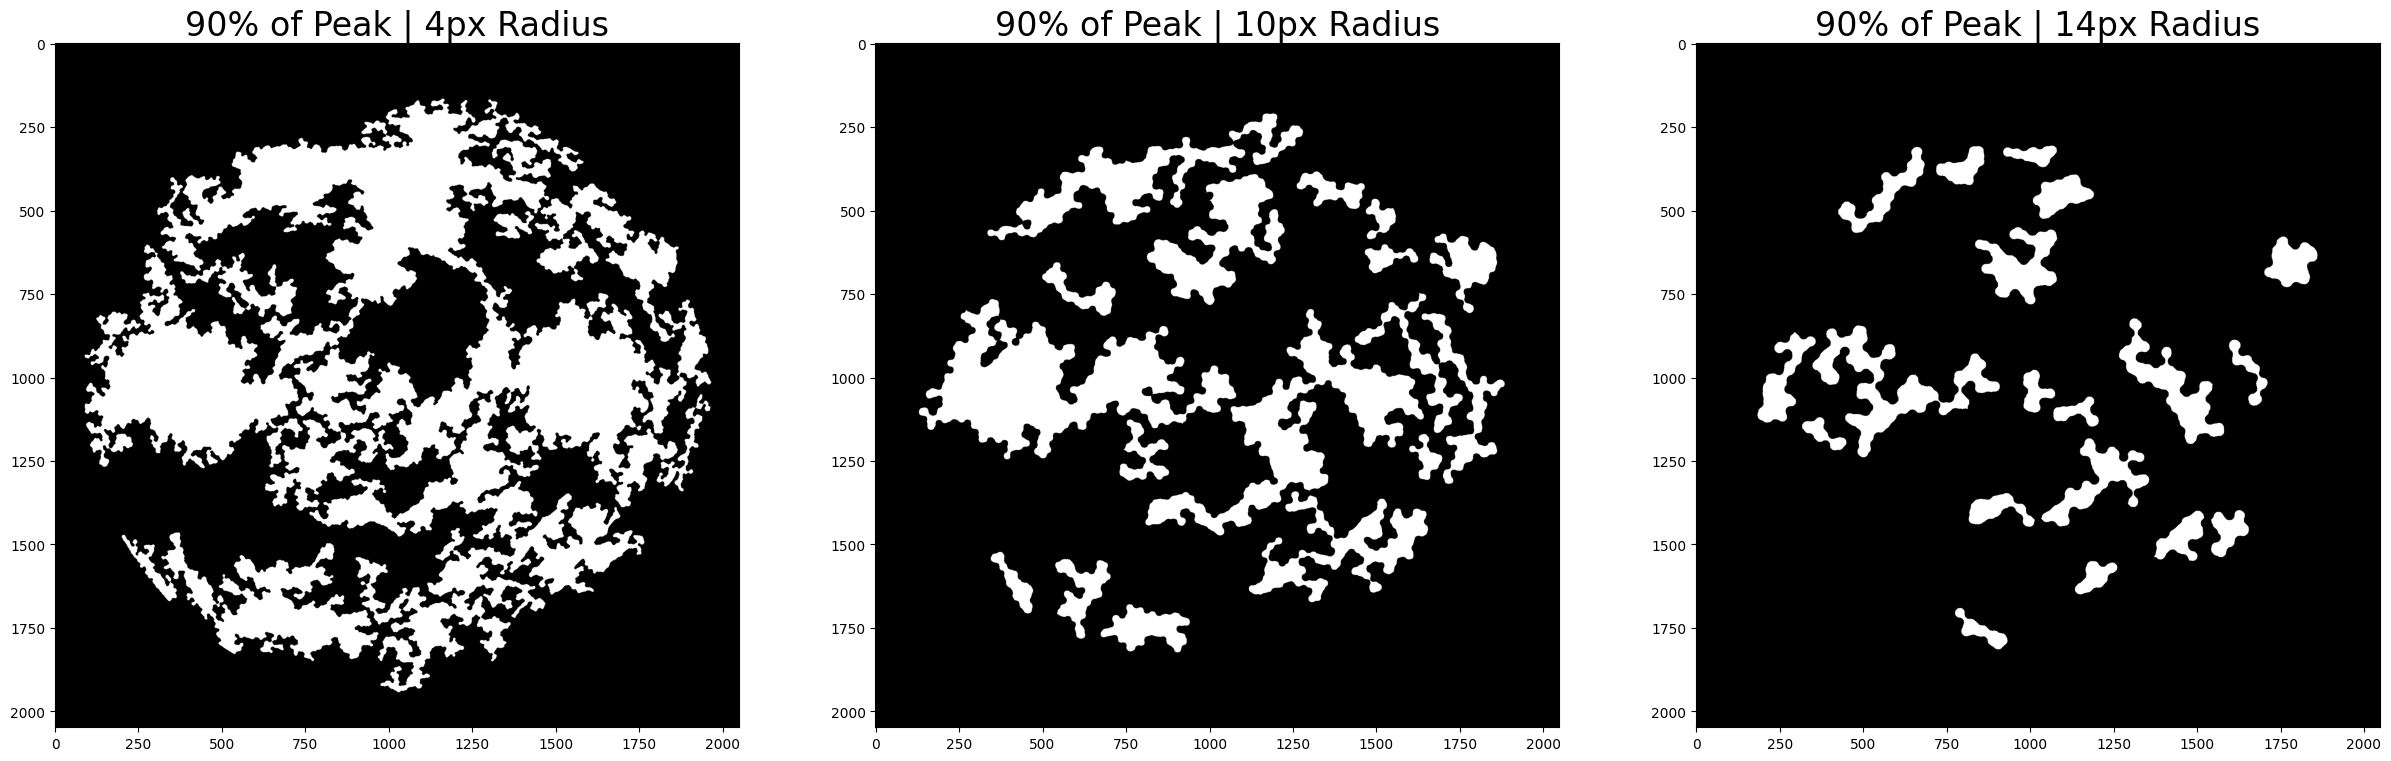

In [9]:
date_str = '2012_06_22__18_13'

raw_eqw = HE_FITS_DICT[date_str][0]
pre_processed_map = run_detection.pre_process_eqw_v0_1(raw_eqw)[0]

percent_of_peak_list = [90, 90, 90]
morph_radius_list = [4,10,14]

ch_mask_list = [
    run_detection.get_ch_mask(pre_processed_map, percent_of_peak, morph_radius)
    for percent_of_peak, morph_radius
    in zip(percent_of_peak_list, morph_radius_list)
]
title_list = [f'{percent_of_peak:d}% of Peak | {radius:d}px Radius'
              for percent_of_peak in percent_of_peak_list
              for radius in morph_radius_list]
plot_detection.plot_ims([pre_processed_map, [[0,0],[0,0]]], ['',''])
plot_detection.plot_ims(ch_mask_list[:3], title_list[:3])

## Smoothness: Gradient Median

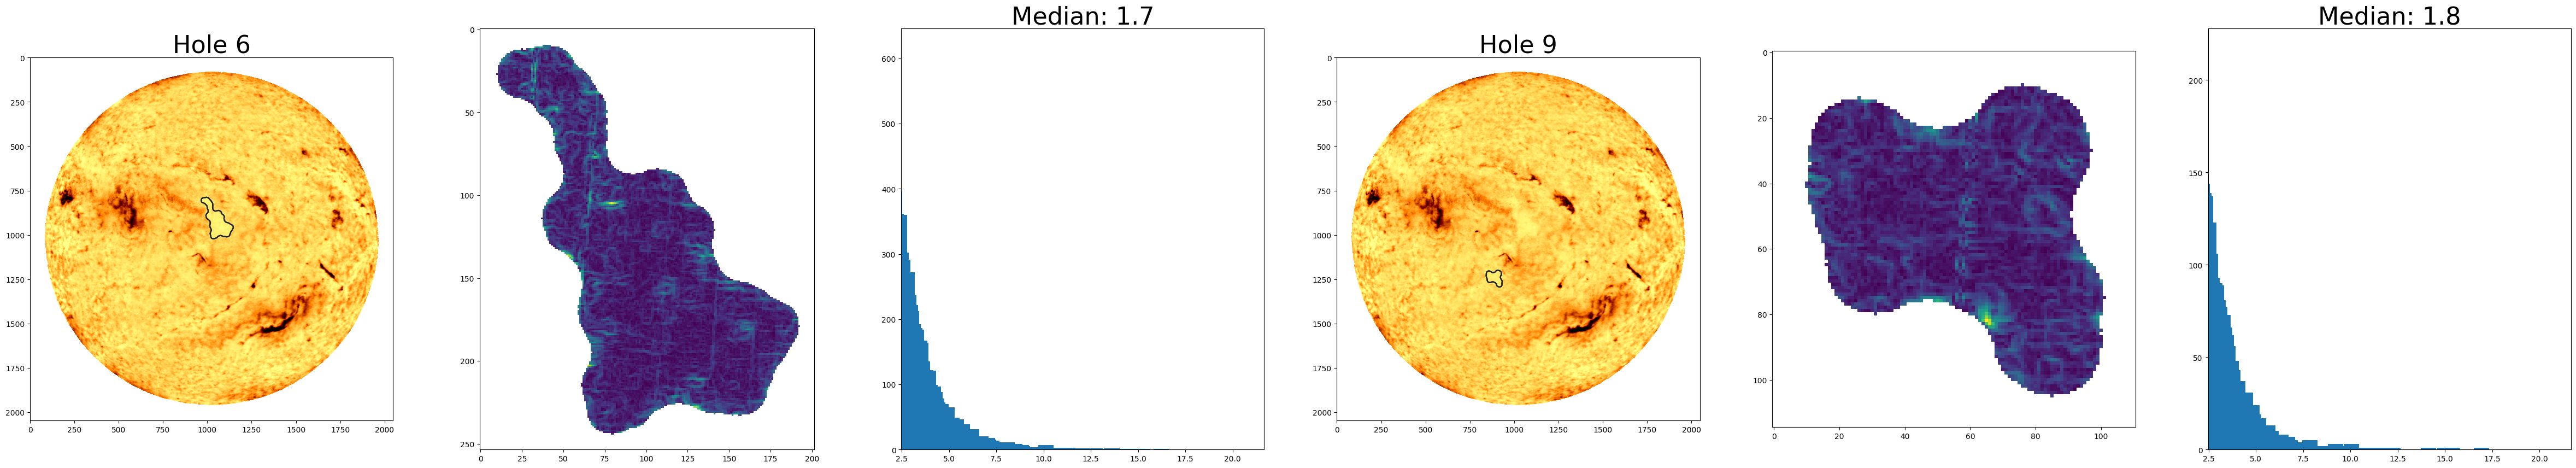

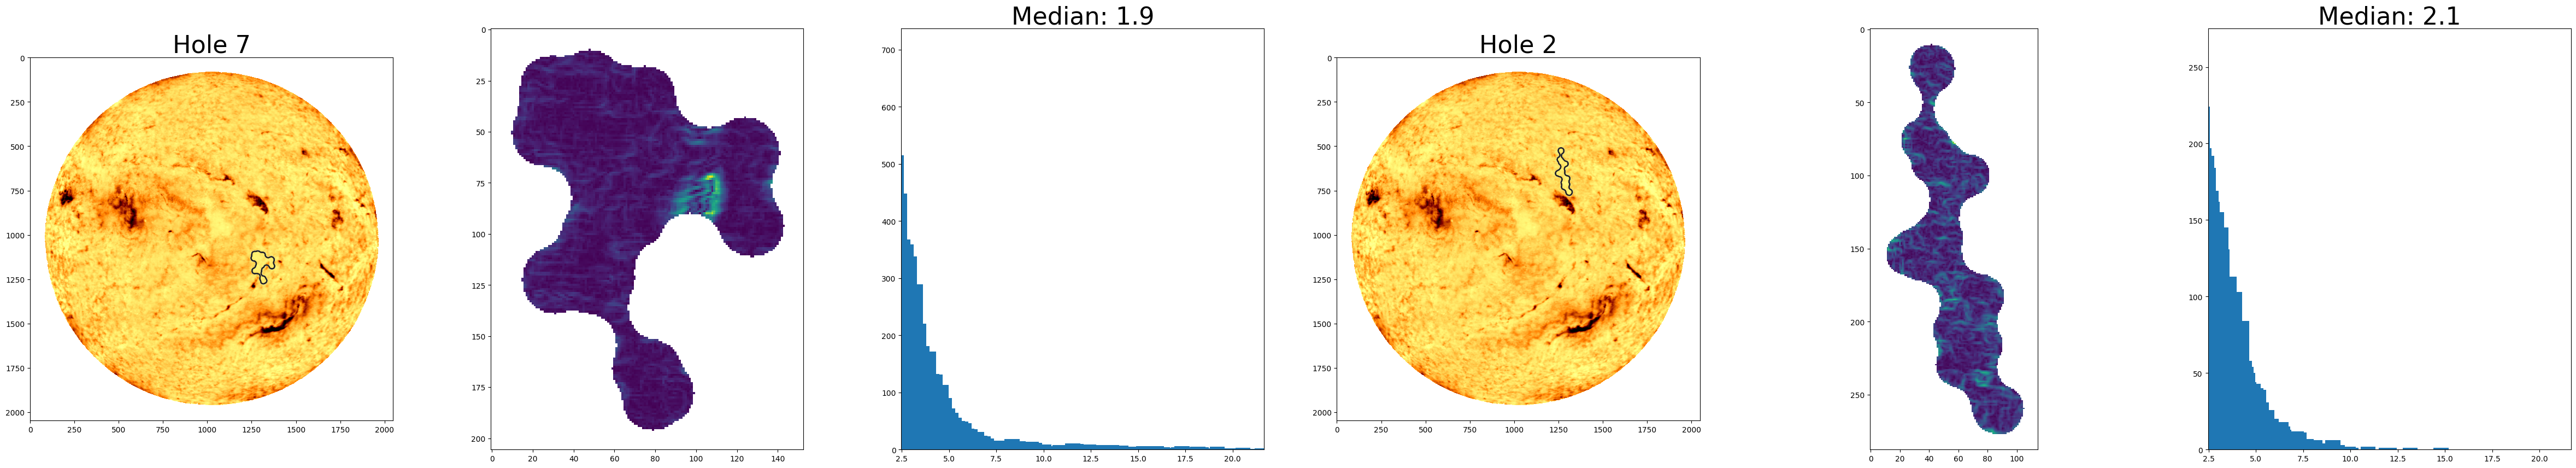

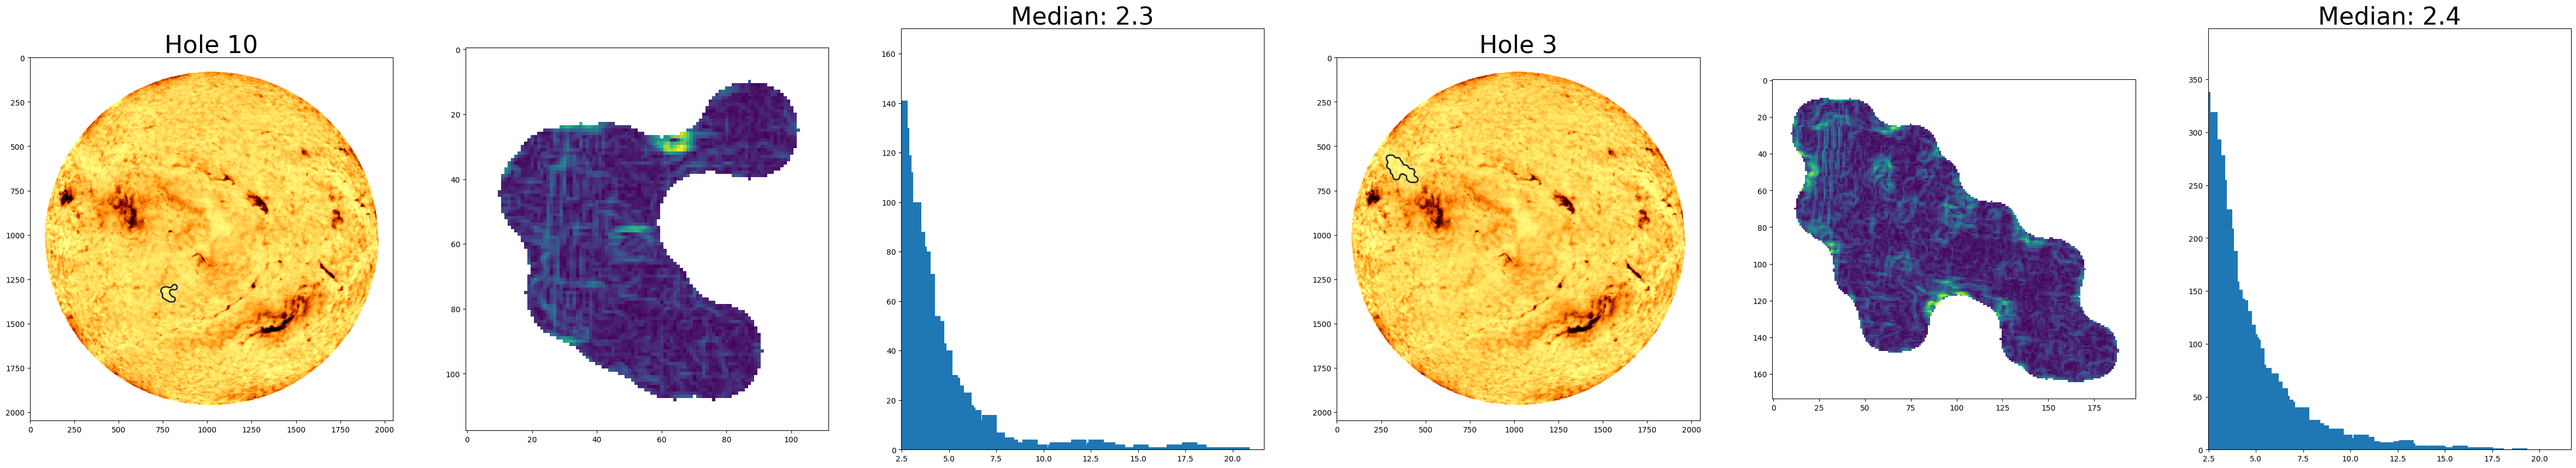

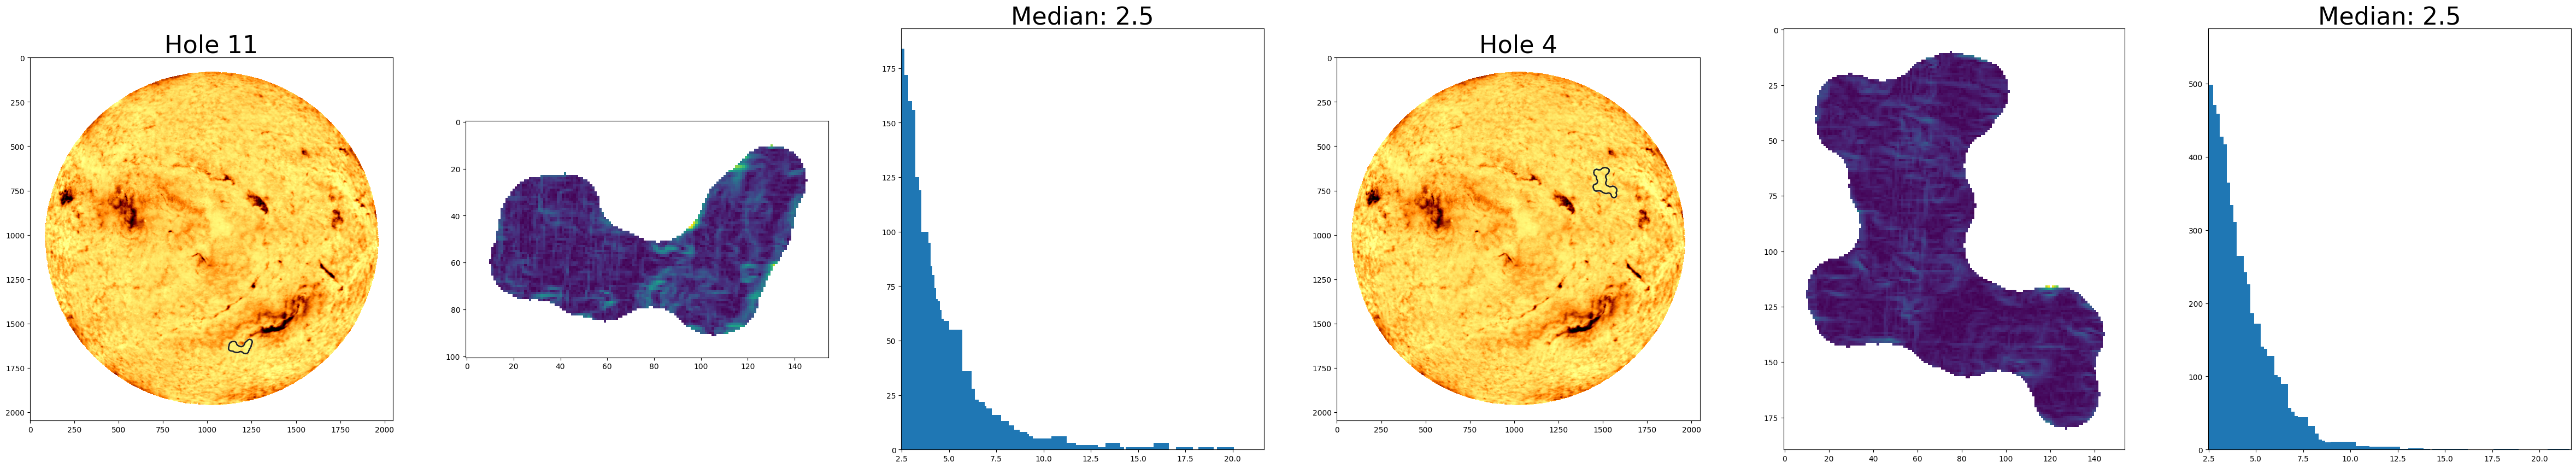

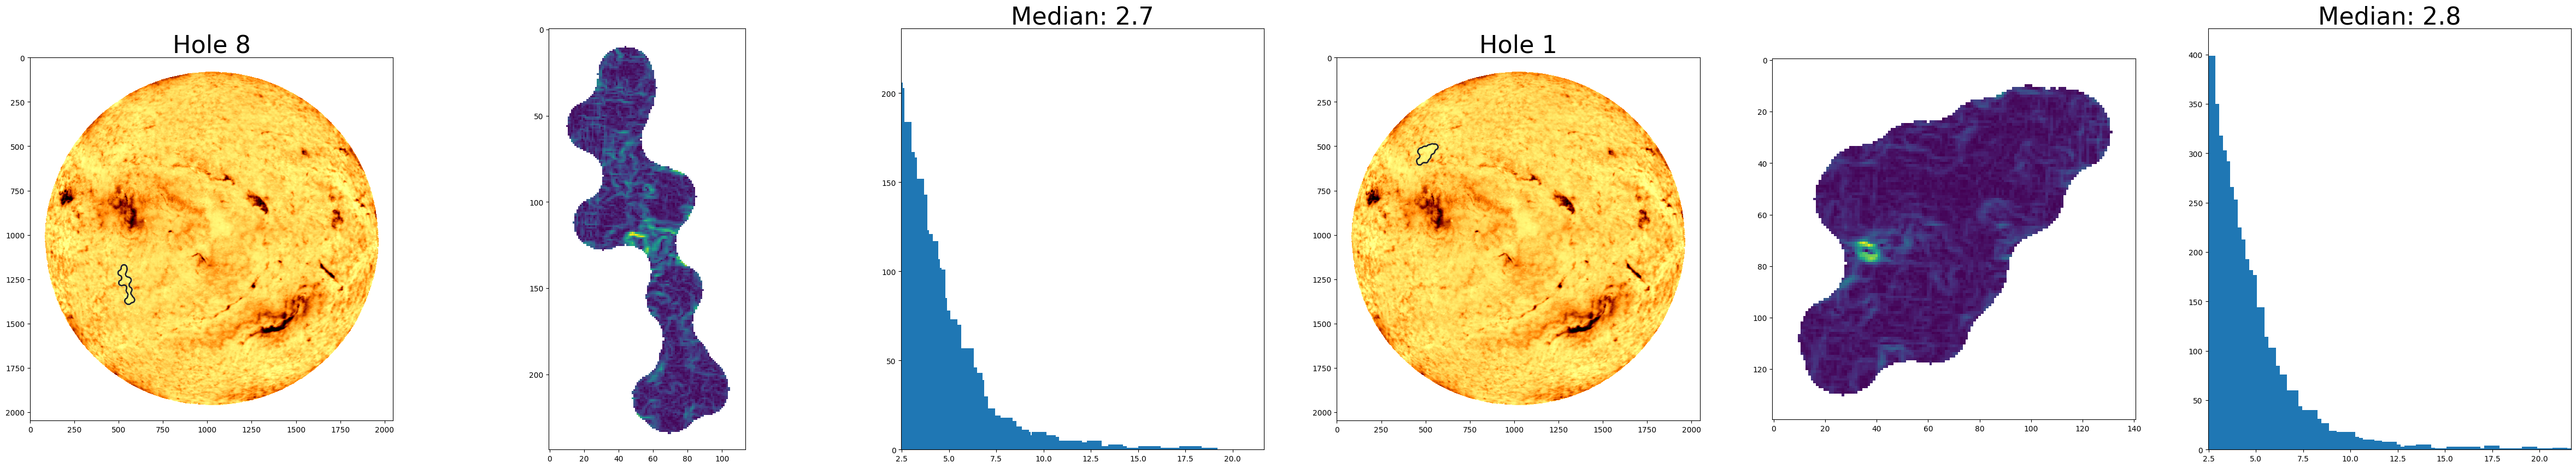

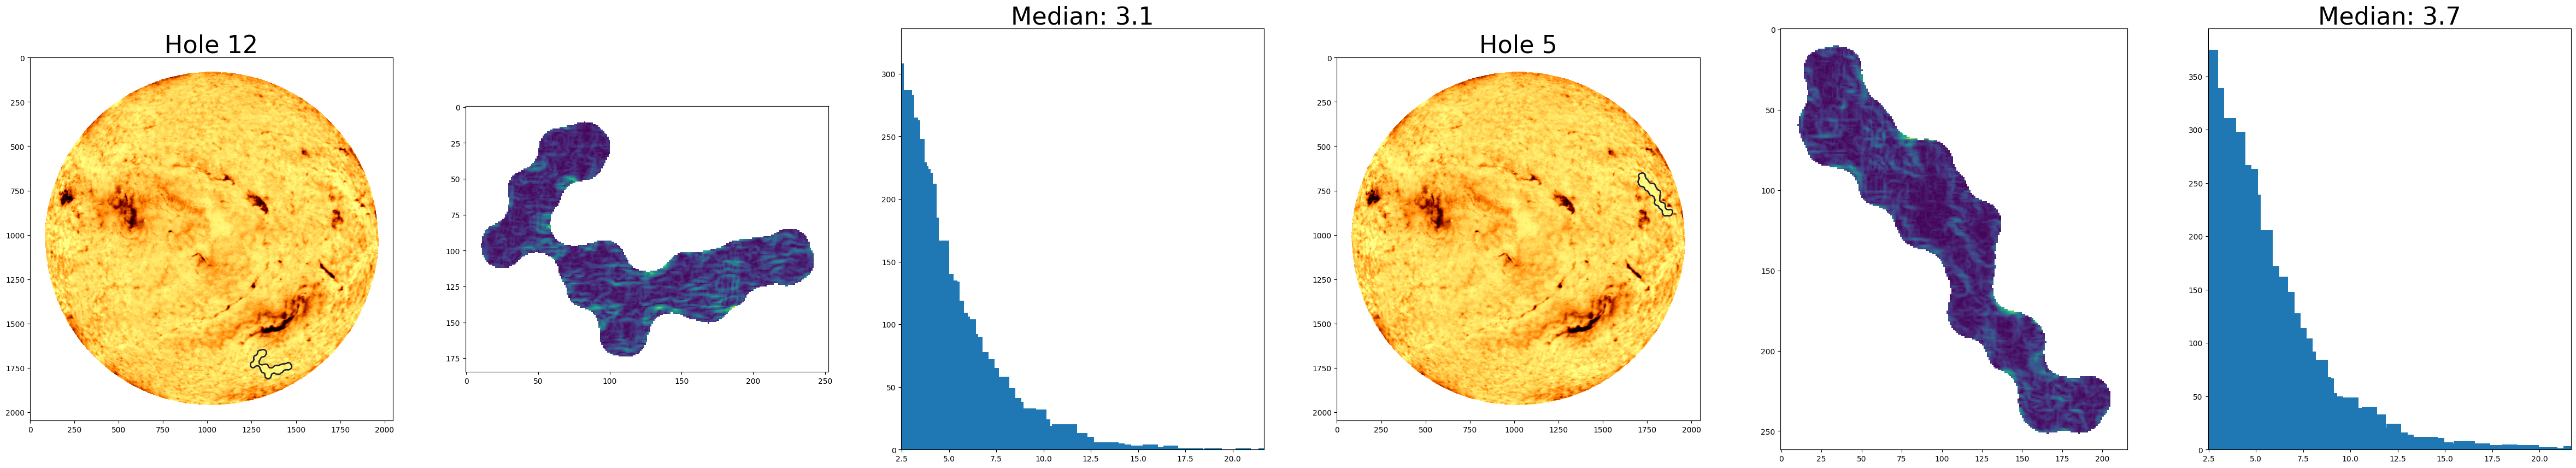

In [37]:
# date_str = '2015_03_31__18_13'
date_str = '2015_07_16__17_12'
percent_of_peak = 90
morph_radius = 15

raw_eqw = HE_FITS_DICT[date_str][0]
pre_processed_map = run_detection.pre_process_eqw_v0_1(raw_eqw)[0]

ch_mask = run_detection.get_ch_mask(pre_processed_map, percent_of_peak, morph_radius)

plot_detection.plot_sorted_ch_hists(pre_processed_map, ch_mask, apply_gradient=True,
                                    hist_stat='median')

# Ensemble

## Individual

In [ ]:
# date_str = '2012_06_22__18_13'
# date_str = '2014_06_26__14_19'
date_str = '2015_03_31__18_13'
# date_str = '2015_07_16__17_12'

percent_of_peak_list = [80,80,90,100,100]
morph_radius_list = [13,17,15,13,17]

raw_eqw = HE_FITS_DICT[date_str][0]
pre_processed_map = run_detection.pre_process_eqw_v0_1(raw_eqw)[0]
ensemble_map, isolated_ch_im_list, confidence_list = run_detection.get_ensemble_v0_3(
    pre_processed_map, percent_of_peak_list, morph_radius_list
)
plot_detection.plot_ensemble(
    pre_processed_map, ensemble_map, confidence_list, isolated_ch_im_list
)

## Save Files

In [86]:
from skimage import exposure


def remove_peak_counts(array):
    """Retrieve an array with the value of peak counts replaced with NaN.
    """
    peak_counts_val = run_detection.get_peak_counts_loc(array, bins_as_percent=False)
    zero_vals = (array > peak_counts_val - 1e-2) & (array < peak_counts_val + 1e-2)
    
    return np.where(zero_vals, np.NaN, array)


def remove_background(array):
    """Retrieve an array with the background replaced with NaN.
    """
    background_val = array[0,0]    
    return np.where(array == background_val, np.NaN, array)


def band_pass(raw_eqw):
    """Pre-process equivalent width array by setting background to NaN
    and a simple brightness band pass.
    """
    eqw_nan = np.where(raw_eqw == 0, np.NaN, raw_eqw)
    
    eqw_high_cut = np.where(eqw_nan > 100, np.NaN, eqw_nan)
    # eqw_band_cut = np.where(eqw_high_cut < -100, np.NaN, eqw_high_cut)
    eqw_band_cut = np.clip(eqw_high_cut, -100, 100)
    
    return eqw_band_cut, eqw_high_cut, eqw_nan


def equalize(raw_eqw):
    """Pre-process equivalent width array by setting background to NaN
    and a simple brightness band pass.
    """
    # Histogram equalization
    eqw1 = exposure.equalize_hist(raw_eqw)
    eqw1 = remove_background(eqw1)
    
    # Shift nonzero values into positive range and equalize histogram
    eqw2 = np.where(raw_eqw == 0, 0, raw_eqw + np.abs(np.min(raw_eqw)))
    eqw3 = exposure.equalize_hist(eqw2)
    
    eqw3 = np.where(eqw3 == np.min(eqw3), np.NaN, eqw3)
    
    return eqw3, eqw2, eqw1


def rescale(raw_eqw):
    """Pre-process equivalent width array by applying linear rescaling
    to normalize the contrast and setting background to NaN. Linear
    rescaling between 2-98 percentiles produces a less harsh contrast
    enhancement than histogram equalization.
    """
    p2, p98 = np.percentile(raw_eqw, (2, 98))
    
    # Shift nonzero values into positive range and normalize
    eqw1 = np.where(raw_eqw == 0, 0, raw_eqw + np.abs(np.min(raw_eqw)))
    eqw2 = exposure.rescale_intensity(eqw1, in_range=(p2, p98))
    
    # Normalize directly
    eqw3 = exposure.rescale_intensity(raw_eqw, in_range=(p2, p98))
    eqw3 = remove_background(eqw3)
        
    return eqw3, eqw2, eqw1


def rescale_center(raw_eqw):
    """Pre-process equivalent width array by applying linear rescaling
    to normalize the contrast, set background to NaN, and centering mode
    to 0.5.
    """
    p2, p98 = np.percentile(raw_eqw, (2, 98))
    
    # Linearly rescale
    eqw1 = exposure.rescale_intensity(raw_eqw, in_range=(p2, p98))    
    eqw2 = remove_background(eqw1)
    
    # Center mode to zero
    peak_counts_val = run_detection.get_peak_counts_loc(eqw2, bins_as_percent=False)
    eqw3 = eqw2 - peak_counts_val + 0.5

    return eqw3, eqw2, eqw1

Pre-Processed Maps

In [87]:
overwrite = True

if not os.path.isdir(PRE_PROCESS_MAP_SAVE_DIR):
    os.makedirs(PRE_PROCESS_MAP_SAVE_DIR)

# for he_date_str in HE_DATE_LIST[date_idx:date_idx + 3]:
for he_date_str in HE_DATE_LIST:
    
    # Optionally overwrite existing files
    pre_process_file = (PRE_PROCESS_MAP_SAVE_DIR + he_date_str
                        + '_pre_processed_map.npy')
    if os.path.isfile(pre_process_file) and not overwrite:
        print((f'He {he_date_str} pre-processed map already exists.'))
        continue
    
    raw_eqw = HE_FITS_DICT[he_date_str][0]
    # pre_processed_map = run_detection.pre_process_eqw_v0_1(raw_eqw)[0]
    pre_processed_map = rescale_center(raw_eqw)[0]
    
    save_list = [he_date_str, pre_processed_map]
    np.save(pre_process_file, np.array(save_list, dtype=object), 
            allow_pickle=True)
    print(f'{he_date_str} Pre-Processed Map Saved')

2012_06_01__17_15 Pre-Processed Map Saved
2012_06_02__21_21 Pre-Processed Map Saved
2012_06_04__17_18 Pre-Processed Map Saved
2012_06_05__17_16 Pre-Processed Map Saved
2012_06_06__19_11 Pre-Processed Map Saved
2012_06_07__18_10 Pre-Processed Map Saved
2012_06_08__19_51 Pre-Processed Map Saved
2012_06_09__19_20 Pre-Processed Map Saved
2012_06_10__17_44 Pre-Processed Map Saved
2012_06_11__18_01 Pre-Processed Map Saved
2012_06_12__16_59 Pre-Processed Map Saved
2012_06_13__17_20 Pre-Processed Map Saved
2012_06_14__17_41 Pre-Processed Map Saved
2012_06_15__17_01 Pre-Processed Map Saved
2012_06_16__19_29 Pre-Processed Map Saved
2012_06_17__18_07 Pre-Processed Map Saved
2012_06_18__17_16 Pre-Processed Map Saved
2012_06_19__17_56 Pre-Processed Map Saved
2012_06_20__19_06 Pre-Processed Map Saved
2012_06_21__18_53 Pre-Processed Map Saved
2012_06_22__18_13 Pre-Processed Map Saved
2012_06_23__18_34 Pre-Processed Map Saved
2012_06_25__16_50 Pre-Processed Map Saved
2012_06_26__16_51 Pre-Processed Ma

Ensemble Maps (Expensive computation)

In [90]:
overwrite = True

# v0.2
# O X X
# X O O
# X O X
percent_of_peak_list = [80,80, 90, 100,100]
morph_radius_list = [15,17, 13, 13,17]

if not os.path.isdir(ENSEMBLE_MAP_SAVE_DIR):
    os.makedirs(ENSEMBLE_MAP_SAVE_DIR)

for he_date_str in HE_DATE_LIST:
    
    # Optionally overwrite existing files
    ensemble_file = f'{ENSEMBLE_MAP_SAVE_DIR}{he_date_str}_ensemble_map.npy'
    if os.path.isfile(ensemble_file) and not overwrite:
        print((f'He {he_date_str} ensemble map already exists.'))
        continue
    
    pre_process_file = (PRE_PROCESS_MAP_SAVE_DIR + he_date_str
                        + '_pre_processed_map.npy')
    pre_processed_map = np.load(pre_process_file, allow_pickle=True)[-1]

    ensemble_map = run_detection.get_ensemble_v0_3(
        pre_processed_map, percent_of_peak_list, morph_radius_list
    )[0]
    
    save_list = [he_date_str, percent_of_peak_list, morph_radius_list, ensemble_map]
    np.save(ensemble_file, np.array(save_list, dtype=object), allow_pickle=True)
    print(f'{he_date_str} Ensemble Map Saved')

2012_06_02__21_21 Ensemble Map Saved
2012_06_04__17_18 Ensemble Map Saved
2012_06_05__17_16 Ensemble Map Saved
2012_06_06__19_11 Ensemble Map Saved
2012_06_07__18_10 Ensemble Map Saved
2012_06_08__19_51 Ensemble Map Saved
2012_06_09__19_20 Ensemble Map Saved
2012_06_10__17_44 Ensemble Map Saved
2012_06_11__18_01 Ensemble Map Saved
2012_06_12__16_59 Ensemble Map Saved
2012_06_13__17_20 Ensemble Map Saved
2012_06_14__17_41 Ensemble Map Saved
2012_06_15__17_01 Ensemble Map Saved
2012_06_16__19_29 Ensemble Map Saved
2012_06_17__18_07 Ensemble Map Saved
2012_06_18__17_16 Ensemble Map Saved
2012_06_19__17_56 Ensemble Map Saved
2012_06_20__19_06 Ensemble Map Saved
2012_06_21__18_53 Ensemble Map Saved
2012_06_22__18_13 Ensemble Map Saved
2012_06_23__18_34 Ensemble Map Saved
2012_06_25__16_50 Ensemble Map Saved
2012_06_26__16_51 Ensemble Map Saved
2012_06_27__16_15 Ensemble Map Saved
2012_06_28__16_44 Ensemble Map Saved
2012_06_29__16_43 Ensemble Map Saved


## Save Media

EQW & Ensemble Map Images

In [89]:
output_dir = ENSEMBLE_MAPS_DIR


if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for he_date_str in HE_DATE_LIST:
    
    pre_process_file = (PRE_PROCESS_MAP_SAVE_DIR + he_date_str
                        + '_pre_processed_map.npy')
    pre_processed_map = np.load(pre_process_file, allow_pickle=True)[-1]
    
    ensemble_file = f'{ENSEMBLE_MAP_SAVE_DIR}{he_date_str}_ensemble_map.npy'
    ensemble_map = np.load(ensemble_file, allow_pickle=True)[-1]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax = axes.ravel()

    ax[0].set_title(he_date_str, fontsize=24)
    ax[0].imshow(pre_processed_map, cmap=plt.cm.gray)
    
    ax[1].imshow(ensemble_map, cmap=plt.cm.magma)

    plt.savefig(f'{output_dir}{he_date_str}.jpg')
    plt.close(fig)
    print(f'{he_date_str} map saved.')

2012_06_01__17_15 map saved.


Pre-Process Moments vs Time

In [91]:
import pandas as pd
from datetime import datetime

hist_stat_list = []

for he_date_str in HE_DATE_LIST:
    pre_process_file = (PRE_PROCESS_MAP_SAVE_DIR + he_date_str
                        + '_pre_processed_map.npy')
    pre_processed_map_data = np.load(pre_process_file, allow_pickle=True)[-1]
    
    peak_counts_val = run_detection.get_peak_counts_loc(
        pre_processed_map_data, bins_as_percent=False
    )
    hist_stat_list.append(
        [peak_counts_val, np.nanstd(pre_processed_map_data)]
    )

# Convert to dataframes
datetime_list = [datetime.strptime(he_date_str, DICT_DATE_STR_FORMAT)
                 for he_date_str in HE_DATE_LIST]
hist_df = pd.DataFrame(
    hist_stat_list, columns=['Peak', 'StDev'],
    index=datetime_list
)

In [92]:
overwrite = True
output_dir = ENSEMBLE_MAP_IMAGE_DIR + 'Histogram_Moments/'
cmap = 'plasma'
ylabel = 'Histogram Moments'


if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for he_date_str in HE_DATE_LIST[24:25]:
    
    # Optionally overwrite existing files
    img_file = f'{output_dir}{he_date_str}.jpg'
    if os.path.isfile(img_file) and not overwrite:
        print((f'He {he_date_str} map already exists.'))
        continue
    
    pre_process_file = (PRE_PROCESS_MAP_SAVE_DIR + he_date_str
                        + '_pre_processed_map.npy')
    pre_processed_map = np.load(pre_process_file, allow_pickle=True)[-1]
    
    hist, edges = run_detection.get_hist(pre_processed_map,
                                         bins_as_percent=False)
    
    ensemble_file = f'{ENSEMBLE_MAP_SAVE_DIR}{he_date_str}_ensemble_map.npy'
    ensemble_map = np.load(ensemble_file, allow_pickle=True)[-1]
    
    fig = plt.figure(figsize=(18, 10))
    
    ax = fig.add_subplot(231)
    ax.set_title(he_date_str)
    ax.imshow(pre_processed_map, cmap=plt.cm.gray)
    
    ax = fig.add_subplot(232)
    ax.set_title('Semilog Histogram')
    ax.semilogy(edges[1:], hist)
    if 'Rescale' in ENSEMBLE_MAPS_DIR:
        ax.set_ylim([1E2, 5E4])
    else:
        ax.set_xlim([-110, 110])
        ax.set_ylim([1E1, 5E4])
    
    ax = fig.add_subplot(233)
    ax.imshow(ensemble_map, cmap=plt.cm.magma)
    
    ax = fig.add_subplot(2, 3, (4, 6))
    datetimes = hist_df.index
    ax.plot(hist_df['StDev'], label='Standard Deviation', linewidth=3)
    ax.plot(hist_df['Peak'], label='Mode', linewidth=3)
    
    # Vertical line for datetime indicator
    vline_datetime = datetime.strptime(he_date_str, DICT_DATE_STR_FORMAT)
    min_moment = min(hist_df.min())
    max_moment = max(hist_df.max())
    ax.vlines(x=[vline_datetime, vline_datetime], ymax=2*max_moment, ymin=0,
              colors='k', linestyles='dashed')
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim([datetimes[0], datetimes[-1]])
    ax.set_ylim([0.9*min_moment, 1.1*max_moment])
    
    ax.legend(reverse=True)

    plt.savefig(img_file)
    plt.close(fig)
    print(f'{he_date_str} map saved.')

2012_06_27__16_15 map saved.


Pre-Process Outcomes vs Time

In [ ]:
percent_of_peak_list = [80, 90, 100, 110]
num_ch_df, area_percent_df, area_df, px_percent_df = run_detection.get_thresh_outcome_dfs(
    HE_DATE_LIST, percent_of_peak_list, ALL_HE_DIR, PRE_PROCESS_MAP_SAVE_DIR
)

In [20]:
overwrite = True
output_dir = ENSEMBLE_MAP_IMAGE_DIR + 'Thresh_Area_Percentage/'
outcome_df = area_percent_df
cmap = 'plasma'
ylabel = 'Detected Area Percentage (%)'


if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for he_date_str in HE_DATE_LIST[24:25]:
    
    # Optionally overwrite existing files
    img_file = f'{output_dir}{he_date_str}.jpg'
    if os.path.isfile(img_file) and not overwrite:
        print((f'He {he_date_str} map already exists.'))
        continue
    
    pre_process_file = (PRE_PROCESS_MAP_SAVE_DIR + he_date_str
                        + '_pre_processed_map.npy')
    pre_processed_map = np.load(pre_process_file, allow_pickle=True)[-1]
    
    hist, edges = run_detection.get_hist(pre_processed_map,
                                         bins_as_percent=False)
    
    ensemble_file = f'{ENSEMBLE_MAP_SAVE_DIR}{he_date_str}_ensemble_map.npy'
    ensemble_map = np.load(ensemble_file, allow_pickle=True)[-1]
    
    fig = plt.figure(figsize=(18, 10))
    
    ax = fig.add_subplot(231)
    ax.set_title(he_date_str)
    ax.imshow(pre_processed_map, cmap=plt.cm.gray)
    
    ax = fig.add_subplot(232)
    ax.set_title('Semilog Histogram')
    ax.semilogy(edges[1:], hist)
    if ENSEMBLE_MAPS_DIR == OUTPUT_DIR + 'Rescale/':
        ax.set_ylim([1E2, 5E4])
    else:
        ax.set_xlim([-110, 110])
        ax.set_ylim([1E1, 5E4])
    
    ax = fig.add_subplot(233)
    ax.imshow(ensemble_map, cmap=plt.cm.magma)
    
    ax = fig.add_subplot(2, 3, (4, 6))    
    plot_detection.plot_thresh_outcome_vs_time(
        ax, outcome_df, he_date_str, cmap, ylabel)

    plt.savefig(img_file)
    plt.close(fig)
    print(f'{he_date_str} map saved.')

2012_06_27__16_15 map saved.


Pre-Process Outcomes vs Method

In [6]:
percent_of_peak_list = [80, 90, 100, 110]
area_percent_df_by_method_list = []
mad_by_thresh_by_method_list = []

for ensemble_maps_dir in ['Ensemble_Maps_v0_3/', 'Band_Pass/', 'Rescale/']:
    pre_process_map_save_dir = OUTPUT_DIR + ensemble_maps_dir + 'Preprocess_Map_Files/'
    
    area_percent_df = run_detection.get_thresh_outcome_dfs(
        HE_DATE_LIST, percent_of_peak_list, ALL_HE_DIR, pre_process_map_save_dir
    )[1]
    area_percent_df_by_method_list.append(area_percent_df)
    mad_by_thresh_by_method_list.append(
        run_detection.get_mad_by_confidences(area_percent_df, percent_of_peak_list)
    )

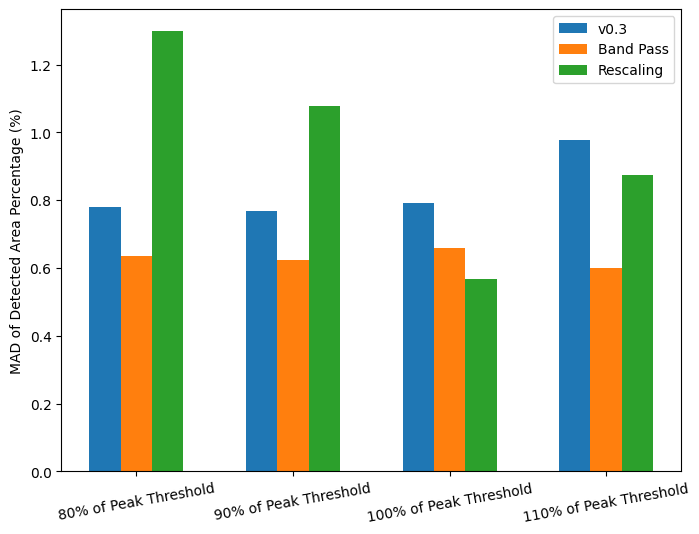

In [12]:
x_ticks = np.arange(len(percent_of_peak_list))
threshold_label_list = [
    f'{thresh_level}% of Peak Threshold'
    for thresh_level in percent_of_peak_list
]

plt.figure(1, figsize=(8,6))

plt.bar(x_ticks - 0.2, mad_by_thresh_by_method_list[0], width=0.2, label='v0.3')
plt.bar(x_ticks, mad_by_thresh_by_method_list[1], width=0.2, label='Band Pass')
plt.bar(x_ticks + 0.2, mad_by_thresh_by_method_list[2], width=0.2, label='Rescaling')
plt.xticks(x_ticks, threshold_label_list, rotation=10)
plt.ylabel(f'MAD of Detected Area Percentage (%)')
plt.legend()

Write Images to Video

In [66]:
run_detection.write_ensemble_video(output_dir, fps=2)

Moviepy - Building video assets/Output/Ensemble_Maps_v0_3/2012_06/Histogram_Moments/ensemble_vid_2fps.mp4.
Moviepy - Writing video assets/Output/Ensemble_Maps_v0_3/2012_06/Histogram_Moments/ensemble_vid_2fps.mp4



Moviepy - Done !
Moviepy - video ready assets/Output/Ensemble_Maps_v0_3/2012_06/Histogram_Moments/ensemble_vid_2fps.mp4
